# Построение модели предсказания потребления электроэнергии в N-регионе

#### Данные потребления электроэнергии в N-регионе
* date – дата
* time – время, время представлено в диапазоне 0 – 23, что означает 24 часа в сутках
* target – Фактическое потребление на указанную дату 
* temp – фактическая температура на указанную дату 
* temp_pred – прогноз температуры на указанную дату 
* weather_fact – фактическая погода на указанную дату 
* weather_pred – прогноз погоды на указанную дату

### Дисклеймер

Данная модель является моим первым самостоятельным проектом, поэтому прошу судить строго, если где-то обнаружите ошибки.

Буду очень рад обратной связи и советам по улучшению модели.

Со мной можно связаться в Telegram @andrrey_a

### Загружаю библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import requests 
from urllib.parse import urlencode 
# Игнорировать все предупреждения
import warnings
warnings.filterwarnings('ignore')

### Загружаю датафреймы

In [2]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/6Rs2ueAEgIGnVA'
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
# загружаем файл в df 
download_response = requests.get(download_url) 
df_train_default = pd.read_csv(download_url, sep=',') 

In [3]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/_FPAQo4EaoW0Ug'
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
# загружаем файл в df 
download_response = requests.get(download_url) 
df_test_default = pd.read_csv(download_url, sep=',') 

## EDA

In [4]:
df_train_default.head(10)

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
5,2019-01-01,5,403.195,4.3,2.0,"пасм, ветер","ветер, пасм"
6,2019-01-01,6,398.173,5.3,3.0,"пасм, ветер","ветер, пасм,дождь"
7,2019-01-01,7,402.689,5.3,3.0,"пасм, ветер","ветер, пасм,дождь"
8,2019-01-01,8,407.094,5.3,3.0,"пасм, ветер","ветер, пасм,дождь"
9,2019-01-01,9,414.565,6.0,5.0,"пасм, 80% дождь","ветер, пасм,дождь"


In [5]:
df_test_default.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
1,2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2,2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
3,2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
4,2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"


In [6]:
# Есть несущественные пропуски данных
# Удалю пропуски
# Заменю строку даты на datetime
df_train_default.date = pd.to_datetime(df_train_default.date)
df_train_default.info()
df_train_default.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          37224 non-null  datetime64[ns]
 1   time          37224 non-null  int64         
 2   target        37224 non-null  float64       
 3   temp          37224 non-null  float64       
 4   temp_pred     37136 non-null  float64       
 5   weather_pred  37136 non-null  object        
 6   weather_fact  37223 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 2.0+ MB


date             0
time             0
target           0
temp             0
temp_pred       88
weather_pred    88
weather_fact     1
dtype: int64

In [7]:
df_train = df_train_default.dropna()
df_train.info() #  Проверяем, что пустых значений не осталось

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37135 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          37135 non-null  datetime64[ns]
 1   time          37135 non-null  int64         
 2   target        37135 non-null  float64       
 3   temp          37135 non-null  float64       
 4   temp_pred     37135 non-null  float64       
 5   weather_pred  37135 non-null  object        
 6   weather_fact  37135 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 2.3+ MB


**Проверю влияние удаленных значений на распределения предсказанных температур**

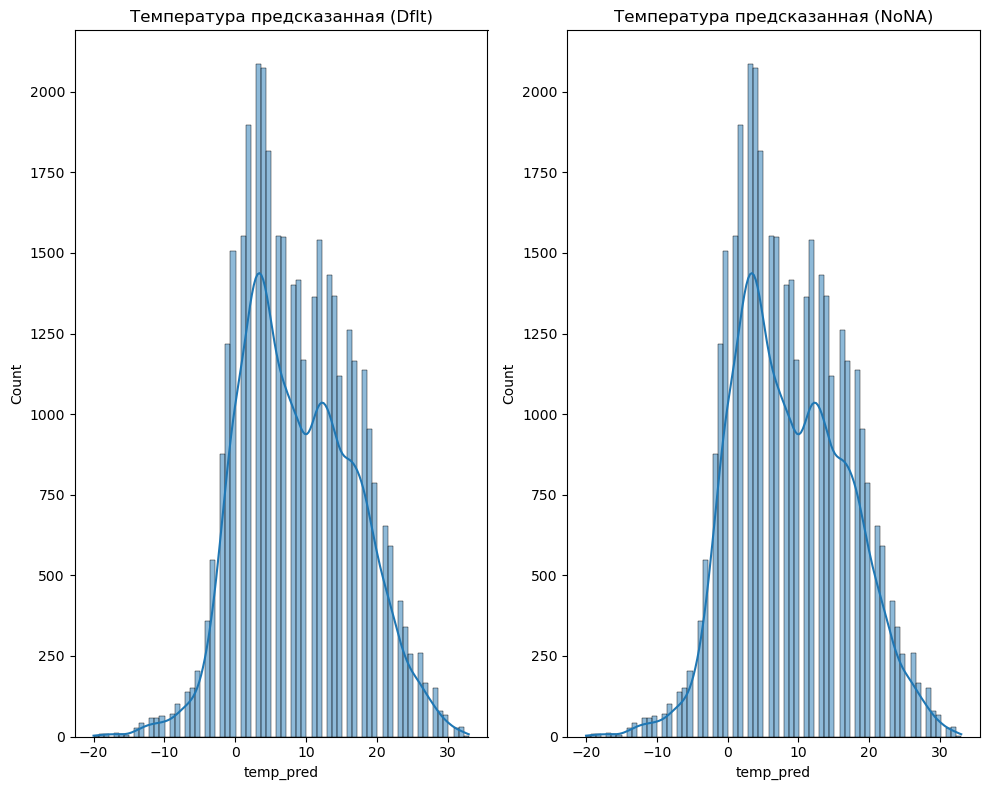

In [8]:
# Создаем сетку для 1x2 графиков (одна строка, две области)
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
# График 1: Температура предсказанная (Dflt)
sns.histplot(df_train_default.temp_pred, kde=True, ax=axes[0])
axes[0].set_title('Температура предсказанная (Dflt)')
# График 2: Температура предсказанная (NoNA)
sns.histplot(df_train.temp_pred, kde=True, ax=axes[1])
axes[1].set_title('Температура предсказанная (NoNA)')
# Регулируем расстояния между графиками
plt.tight_layout()
# Отображаем графики
plt.show()

# ВЫВОД: удаление значений не повлияло на распределение переменной

In [9]:
# Есть несущественные пропуски данных
# Удалю пропуски
# Заменю строку даты на datetime
df_test_default.date = pd.to_datetime(df_test_default.date)
df_test_default.info()
df_test_default.isna().sum()
df_test_default

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2928 non-null   datetime64[ns]
 1   time          2928 non-null   int64         
 2   target        2928 non-null   float64       
 3   temp          2928 non-null   float64       
 4   temp_pred     2904 non-null   float64       
 5   weather_pred  2904 non-null   object        
 6   weather_fact  2928 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 160.3+ KB


,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
1,2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2,2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
3,2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
4,2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...,...
2923,2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2924,2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2925,2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл
2926,2023-07-31,22,449.078,15.8,17.0,"пасм, 24% дождь",п/обл


In [10]:
df_test = df_test_default.dropna()
df_test.info() #  Проверяем, что пустых значений не осталось
df_test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2904 entries, 0 to 2927
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2904 non-null   datetime64[ns]
 1   time          2904 non-null   int64         
 2   target        2904 non-null   float64       
 3   temp          2904 non-null   float64       
 4   temp_pred     2904 non-null   float64       
 5   weather_pred  2904 non-null   object        
 6   weather_fact  2904 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 181.5+ KB


,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
1,2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2,2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
3,2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
4,2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...,...
2923,2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2924,2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2925,2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл
2926,2023-07-31,22,449.078,15.8,17.0,"пасм, 24% дождь",п/обл


**Построю матрицу корреляции для понимания силы взаимодейсствия переменных**

<Axes: >

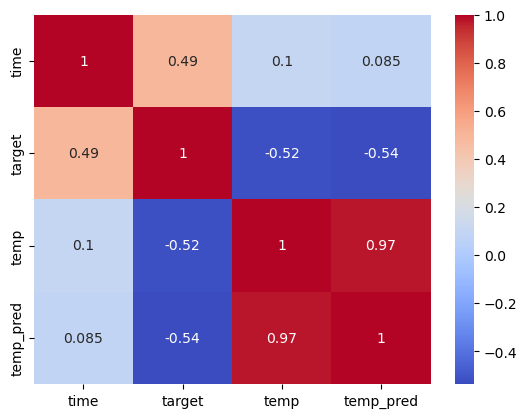

In [11]:
df_train_nums = df_train[['time','target','temp','temp_pred']]
sns.heatmap(df_train_nums.corr(), annot=True, cmap='coolwarm')

#### По матрице корреляций видно:
* сильная положительная взаимосвязь присутствует между переменными temp и temp_pred;
* умеренная положительная взаимосвязь присутствует между переменными time и target;
* слабая отрицательная взаимосвязь присутствует между переменными target и temp / temp_pred;

 **Построю распределения переменных**

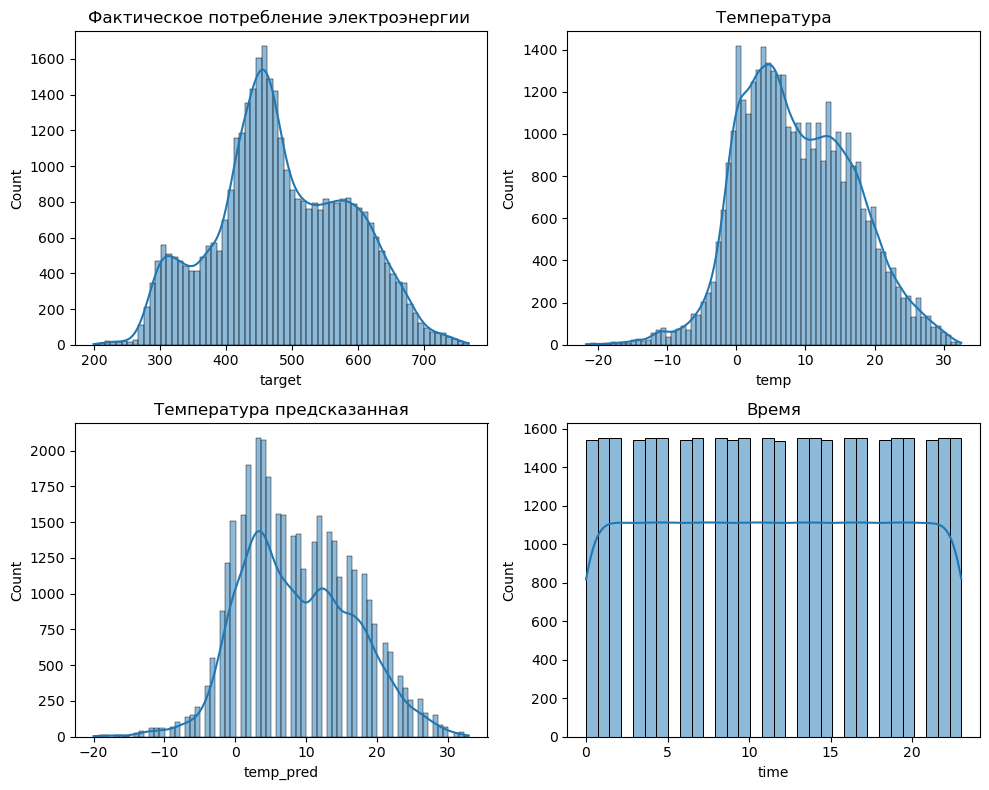

In [12]:
# Создаем сетку для 2x2 графиков
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# График 1: Фактическое потребление электроэнергии
sns.histplot(df_train.target, kde = True,ax=axes[0, 0])
axes[0, 0].set_title('Фактическое потребление электроэнергии ')
# График 2: Температура
sns.histplot(df_train.temp, kde = True,ax=axes[0, 1])
axes[0, 1].set_title('Температура')
# График 3: Температура предсказанная
sns.histplot(df_train.temp_pred, kde = True,ax=axes[1, 0])
axes[1, 0].set_title('Температура предсказанная')
# График 4: Время
sns.histplot(df_train.time, kde = True,ax=axes[1, 1])
axes[1, 1].set_title('Время')
# Регулируем расстояния между графиками
plt.tight_layout()
# Отображаем графики
plt.show()

**Проверю наличие выбросов в числовых переменных**

In [13]:
z_scores = stats.zscore(df_train[['time','target','temp','temp_pred']])
threshold = 3  # Пороговый уровень значимости

outliers = (z_scores > threshold) | (z_scores < -threshold)
outliers.query('time == True & target == True & temp == True & temp_pred == True')
# Выбросов не обнаружено

,time,target,temp,temp_pred


**Анализ категориальных переменных:** 

Рассмотрю категориальные столбцы, такие как weather_pred и weather_fact, и определю, какие значения наиболее часто встречаются, а также проведу анализ наличия корреляции между этими переменными и числовыми.

In [14]:
# Определение наиболее часто встречающихся значений
most_common_weather_pred = df_train['weather_pred'].value_counts().idxmax()
most_common_weather_fact = df_train['weather_fact'].value_counts().idxmax()

print("Наиболее часто встречающиеся значения в 'weather_pred':", most_common_weather_pred)
print("Наиболее часто встречающиеся значения в 'weather_fact':", most_common_weather_fact)

Наиболее часто встречающиеся значения в 'weather_pred': ясно
Наиболее часто встречающиеся значения в 'weather_fact': ясно


In [15]:
# Корреляция
# Создаю таблицу сопряженности для анализа
crosstab = pd.crosstab(df_train['weather_pred'], df_train['weather_fact'])
# Вычисляю коэффициент V-Крамера
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
n = crosstab.sum().sum()
cramer_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))

print("Коэффициент V-Крамера:", cramer_v)

Коэффициент V-Крамера: 0.509853748790972


**ВЫВОД:** в данных существует определенная степень связи между предсказанным и фактическим погодным состоянием. 
Значение коэффициента V-Крамера 0.5099 говорит о том, что эта связь неслабая, но также не является абсолютной.

### Анализ временных трендов

Cтолбцы date и time содержат информацию о времени, поэтому я могу проанализировать временные тренды в данных, например, изменение target в зависимости от даты и времени.

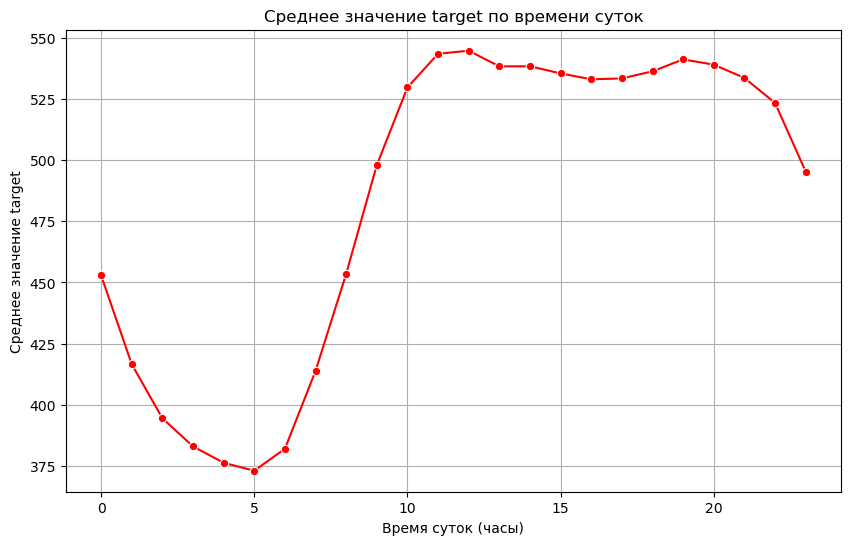

In [16]:
# Агрегирую данные по времени суток
hourly_average = df_train.groupby('time')['target'].mean().reset_index()
# Построю временной график среднего значения target по времени суток
plt.figure(figsize=(10, 6))
sns.lineplot(hourly_average.target,marker='o', color='r')
plt.xlabel('Время суток (часы)')
plt.ylabel('Среднее значение target')
plt.title('Среднее значение target по времени суток')
plt.grid(True)
plt.show()

**ВЫВОД:** точка минимума потребления электроэнергии приходится на 05:00, максимальное потребление держится в промежутке 10:00-21:00 

## Прогнозирование target  

Использую данные temp, temp_pred, weather_pred и weather_fact для создания модели прогнозирования и оценки ее точности.

In [17]:
# Создаем новые столбцы на основе текстовых записей о предсказанных значениях в df_train
df_train['cloudy_p']   = df_train['weather_pred'].str.contains('обл|малообл|пер.об.|п/обл|обл с пр', case=False, regex=True)
df_train['overcast_p'] = df_train['weather_pred'].str.contains('пасм|пасм с пр')
df_train['rain_p']     = df_train['weather_pred'].str.contains('дождь')
df_train['wind_p']     = df_train['weather_pred'].str.contains('ветер|ветрище', case=False, regex=True)
df_train['h_rain_p']   = df_train['weather_pred'].str.contains('ливень')
df_train['storm_p']    = df_train['weather_pred'].str.contains('гроза')
df_train['snow_p']     = df_train['weather_pred'].str.contains('снег|сн', case=False, regex=True)

df_train['cloudy_f']   = df_train['weather_fact'].str.contains('обл|малообл|пер.об.|п/обл|обл с пр', case=False, regex=True)
df_train['overcast_f'] = df_train['weather_fact'].str.contains('пасм|пасм с пр')
df_train['rain_f']     = df_train['weather_fact'].str.contains('дождь')
df_train['wind_f']     = df_train['weather_fact'].str.contains('ветер|ветрище', case=False, regex=True)
df_train['h_rain_f']   = df_train['weather_fact'].str.contains('ливень')
df_train['storm_f']    = df_train['weather_fact'].str.contains('гроза')
df_train['snow_f']     = df_train['weather_fact'].str.contains('снег|сн', case=False, regex=True)

In [18]:
# Создаю псевдозначения для погодных характеристик в df_train
df_train_encoded = pd.get_dummies(df_train, columns=['cloudy_p', 'overcast_p', 'rain_p', 'wind_p', 'h_rain_p', \
                                                     'storm_p', 'snow_p','cloudy_f', 'overcast_f', 'rain_f', \
                                                     'wind_f', 'h_rain_f', 'storm_f', 'snow_f'])
# Удалю исходные столбцы, чтобы не мешали
df_train_encoded = df_train.drop(['weather_pred', 'weather_fact'], axis=1)

**Сгруппирую значения по дате и подсчитаю среднее для перемеенных, участвующих в модели. Переменную temp_pred уберу из расчетов ввиду ее сильной корреляции с переменной temp**

In [19]:
df_train_encoded_mean = df_train_encoded.groupby('date')['temp','target','cloudy_p', 'overcast_p', 'rain_p', 'wind_p', 'h_rain_p', \
                      'storm_p', 'snow_p','cloudy_f', 'overcast_f', 'rain_f', 'wind_f', 'h_rain_f', \
                      'storm_f', 'snow_f'].mean()

#### Обучаю модель

In [20]:
# Подготовка данных
X = df_train_encoded_mean[['temp','cloudy_p', 'overcast_p', 'rain_p', 'wind_p', 'h_rain_p', \
                      'storm_p', 'snow_p','cloudy_f', 'overcast_f', 'rain_f', 'wind_f', 'h_rain_f', \
                      'storm_f', 'snow_f']]
y = df_train_encoded_mean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)
# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)
# Оценка производительности модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
# Вывожу меетрики качества модели
print(f'MAE: {mae}') # это универсальная метрика, которая позволяет узнать разницу между фактическими и прогнозируемыми значениями.
print(f'MSE: {mse}') # gомогает находить ошибки с помощью квадратичной разницы между фактическими и прогнозируемыми значениями.
print(f'RMSE: {rmse}') # показывает разницу между фактическими и прогнозируемыми значениями, извлекая корень квадратный из средней квадратичной ошибки.
print(f'R^2: {r2}')

MAE: 26.466229695139823
MSE: 1110.2106695801845
RMSE: 33.319823972827116
R^2: 0.8127095872834181


In [21]:
# Проверяю эту же модель через библиотеку statmodels
model_formula = 'target ~ temp + cloudy_p + overcast_p + rain_p + wind_p + \
                 h_rain_p + snow_p + storm_p + cloudy_f + overcast_f + rain_f + wind_f + \
                 h_rain_f + snow_f + storm_f'
results = smf.ols(model_formula, data=df_train_encoded_mean).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     470.3
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:16:40   Log-Likelihood:                -7594.8
No. Observations:                1551   AIC:                         1.522e+04
Df Residuals:                    1535   BIC:                         1.531e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    566.4933      5.169    109.588      0.0

#### Предскажем target для df_test и сравним с фактическими значениями

In [22]:
# Создаем новые столбцы на основе текстовых записей в df_test
df_test['cloudy_p']   = df_test['weather_pred'].str.contains('обл|малообл|пер.об.|п/обл|обл с пр', case=False, regex=True)
df_test['overcast_p'] = df_test['weather_pred'].str.contains('пасм|пасм с пр')
df_test['rain_p']     = df_test['weather_pred'].str.contains('дождь')
df_test['wind_p']     = df_test['weather_pred'].str.contains('ветер|ветрище', case=False, regex=True)
df_test['h_rain_p']   = df_test['weather_pred'].str.contains('ливень')
df_test['storm_p']    = df_test['weather_pred'].str.contains('гроза')
df_test['snow_p']     = df_test['weather_pred'].str.contains('снег|сн', case=False, regex=True)

df_test['cloudy_f']   = df_test['weather_fact'].str.contains('обл|малообл|пер.об.|п/обл|обл с пр', case=False, regex=True)
df_test['overcast_f'] = df_test['weather_fact'].str.contains('пасм|пасм с пр')
df_test['rain_f']     = df_test['weather_fact'].str.contains('дождь')
df_test['wind_f']     = df_test['weather_fact'].str.contains('ветер|ветрище', case=False, regex=True)
df_test['h_rain_f']   = df_test['weather_fact'].str.contains('ливень')
df_test['storm_f']    = df_test['weather_fact'].str.contains('гроза')
df_test['snow_f']     = df_test['weather_fact'].str.contains('снег|сн', case=False, regex=True)

In [23]:
# Создам фиктивные данные для тестовой структуры
df_test_encoded = pd.get_dummies(df_test, columns=['cloudy_p', 'overcast_p', 'rain_p', 'wind_p', 'h_rain_p',\
                                                   'storm_p', 'snow_p','cloudy_f', 'overcast_f', 'rain_f', \
                                                   'wind_f', 'h_rain_f', 'storm_f', 'snow_p'])
# Удалю исходные столбцы, чтобы не мешались
df_test_encoded = df_test.drop(['weather_pred', 'weather_fact'], axis=1)

In [24]:
df_test_encoded_mean = df_test_encoded.groupby('date')['temp','target','cloudy_p', 'overcast_p', 'rain_p', 'wind_p', 'h_rain_p', \
                      'storm_p', 'snow_p','cloudy_f', 'overcast_f', 'rain_f', 'wind_f', 'h_rain_f', \
                      'storm_f', 'snow_f'].mean()

#### Предскажу значения потребления по созданной модели и запишу факт и предсказания для сраввнения

In [25]:
# Создаю итоговый датафрейм
df_res = df_test_encoded_mean[['target']].reset_index()
# Подготовка данных в df_test (должна быть аналогичной структуры, как в df_train)
X_test = df_test_encoded_mean[['temp', 'cloudy_p', 'overcast_p', 'rain_p', 'wind_p', 'h_rain_p', 
                               'storm_p', 'snow_p','cloudy_f', 'overcast_f', 'rain_f', 'wind_f', 
                               'h_rain_f', 'storm_f', 'snow_f']]
# Использую модель, чтобы сделать предсказания
target_predict = model.predict(X_test)
# Запишите предсказанные значения в df_test
df_res['target_predict'] = target_predict
df_res

,date,target,target_predict
0,2023-04-01,506.049000,539.080389
1,2023-04-02,501.086208,525.991883
2,2023-04-03,526.415667,531.836782
3,2023-04-04,543.451708,569.504270
4,2023-04-05,544.776917,556.485401
...,...,...,...
117,2023-07-27,403.204625,416.296686
118,2023-07-28,406.450500,439.516048
119,2023-07-29,396.891500,403.210972
120,2023-07-30,387.347667,407.171470


### Визуализирую результаты прогнозирования

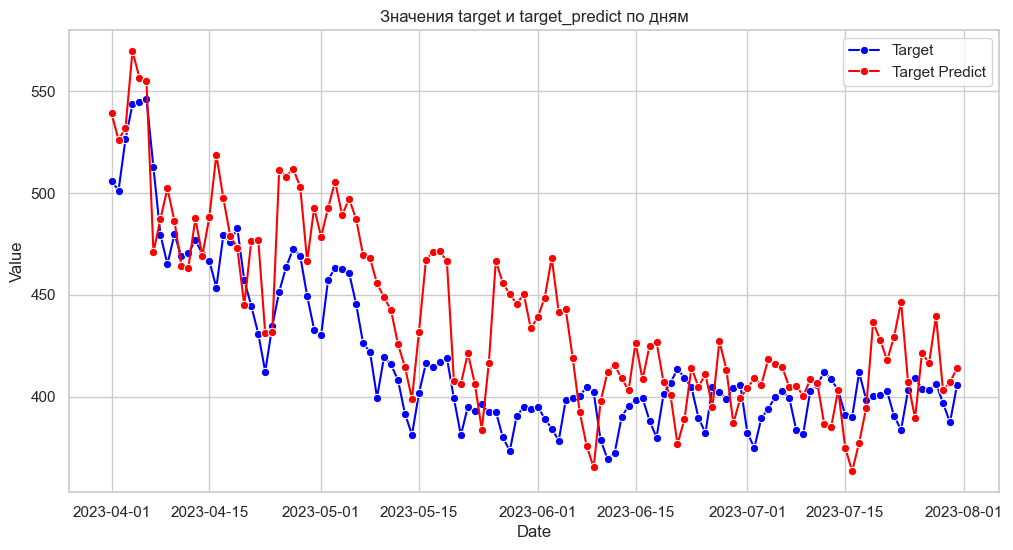

In [26]:
# Устанавливаю стиль графика, создаю фигуры и оси
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
# Строю линейный график для переменной target
sns.lineplot(x='date', y='target', data=df_res, marker='o', label='Target', color = 'blue')
# Строю линейный график для переменной target_predict
sns.lineplot(x='date', y='target_predict', data=df_res, marker='o', label='Target Predict', color = 'red')
# Добавляю заголовок и подписи осей
plt.title('Значения target и target_predict по дням')
plt.xlabel('Date')
plt.ylabel('Value')
# Добавляю легенду и показываю график
plt.legend()
plt.show()

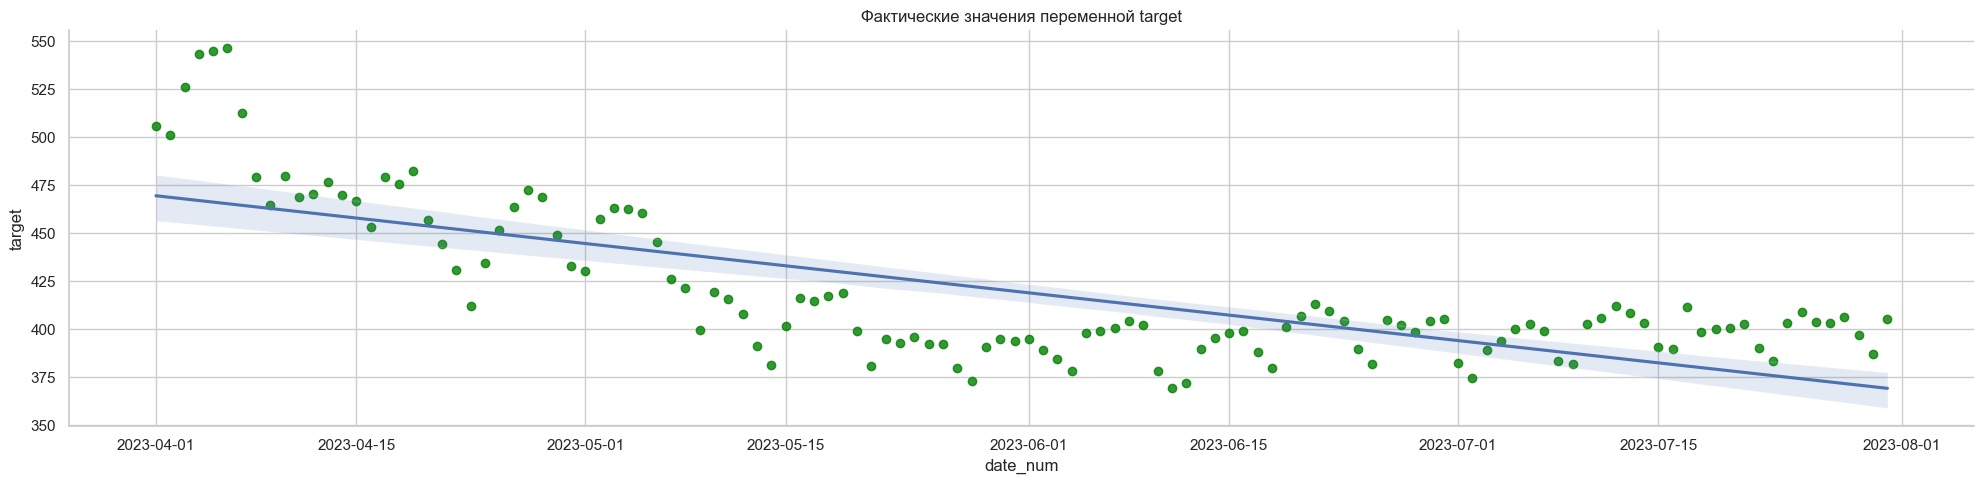

In [27]:
# Перевожу даты в числовой формат, т.к. библиотека нее. работает с датой и временем
df_res['date_num'] = mdates.date2num(df_res['date'])
# Создаю диаграмму рассеивания с линией регрессии
sns.lmplot(x='date_num', y='target', data=df_res, aspect=4,scatter_kws={'color': 'green'})
ax = plt.gca()
# Преобразую числовые значения обратно в даты на оси X (вынужденная хитрость)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Добавляю заголовок
plt.title('Фактические значения переменной target')
# Показываю график
plt.tight_layout() # Для предотвращения наложения меток
plt.show()

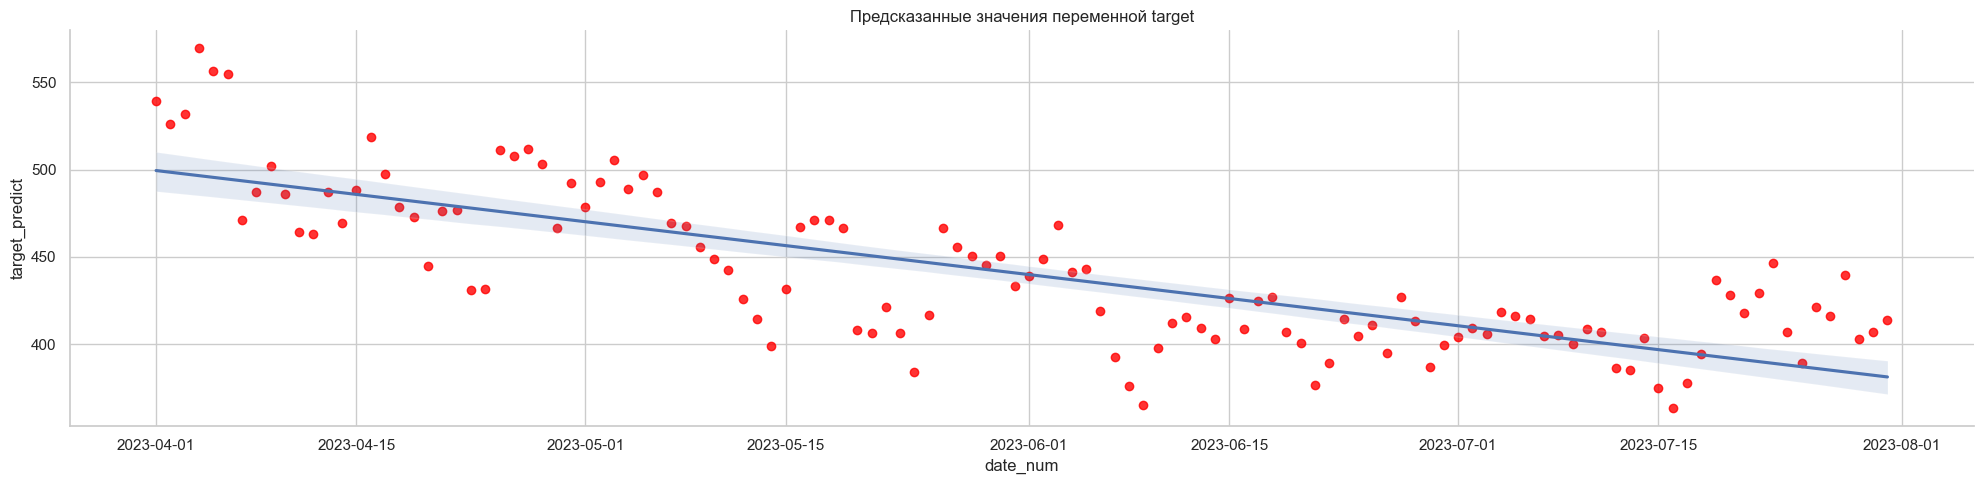

In [28]:
# Создаю диаграмму рассеивания с линией регрессии
sns.lmplot(x='date_num', y='target_predict', data=df_res, aspect=4, scatter_kws={'color': 'red'})
ax = plt.gca()
# Преобразую числовые значения обратно в даты на оси X (хитрость повторяю)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Добавляю заголовок
plt.title('Предсказанные значения переменной target')
# Показываю график
plt.tight_layout() # Для предотвращения наложения меток
plt.show()

<Axes: xlabel='target', ylabel='Count'>

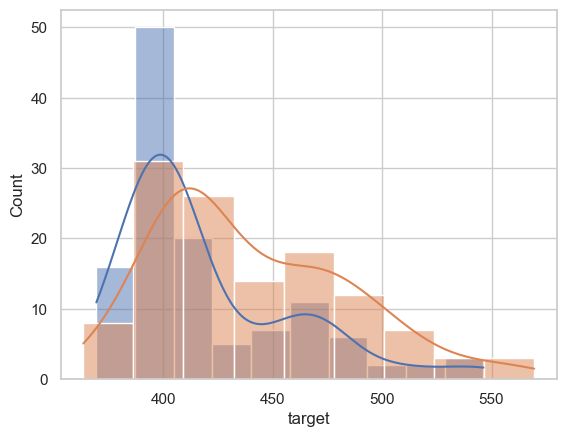

In [29]:
# Строю гистограммы распределений факта (Синий) и предсказанных значений(оранжевый)
sns.histplot(df_res.target, kde = True)
sns.histplot(df_res.target_predict, kde = True)

#### Узнаю в какую сторону работает предсказание в среднем по выборке 
* положительное значение - предсказывает меньшее потребление
* отрицательное значение - предсказывает сверх фактического потребления

In [30]:
df_res['difference'] = df_res['target'] - df_res['target_predict']
df_res['difference'].mean()

-20.87559395979776

## ВЫВОД 

Построенная модель может объяснить 82% вариации зависимой переменной, что является приемлемым результатом. 
В среднем модель предсказывает большее потребление электроэнергии, чем потребляется фактически на 20.9 ед.